In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading Data

In [2]:
!ls '../../Fed_up/data/preprocessed'

recipe_pp_20201117_1347.csv review_pp_20201117_1347.csv


In [3]:
reviews = pd.read_csv('../../Fed_up/data/preprocessed/review_pp_20201117_1347.csv')

In [4]:
reviews.shape[0]

901746

In [5]:
reviews.head()

,recipe_id,user_id,rating,liked,review,date
0,120345,52282,4,1,very very sweet. after i waited the 2 days i b...,2005-05-21
1,120345,124416,0,0,"Just an observation, so I will not rate. I fo...",2011-08-06
2,120345,2000192946,2,0,This recipe was OVERLY too sweet. I would sta...,2015-05-10
3,134728,76535,4,1,Very good!,2005-09-02
4,134728,273745,5,1,Better than the real!!,2005-12-22


In [6]:
reviews = reviews[reviews['rating'] > 0]

(array([ 10117.,      0.,  11010.,      0.,  31817.,      0.,      0.,
        147988.,      0., 652127.]),
 array([0.2 , 0.28, 0.36, 0.44, 0.52, 0.6 , 0.68, 0.76, 0.84, 0.92, 1.  ]),
 <BarContainer object of 10 artists>)

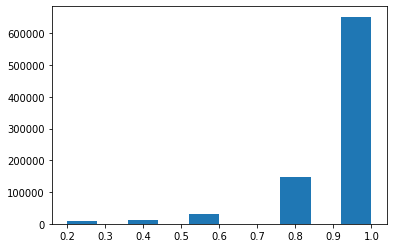

In [18]:
plt.hist(reviews['rating'] / 5)

# Train/Test Split

In [14]:
def generate_test_data(filepath, min_reviews=2):
    
    # Fetching the review dataframe
    print("Fetching the review dataframe...")
    data = pd.read_csv(filepath)
    
    # Creating user / reviews dict
    print("Creating user and reviews dict...")
    user_reviews = data.groupby('user_id') \
                       .agg({'recipe_id': (lambda x: list(x)), 'liked': (lambda x: list(x))}) \
                       .reset_index()
            
    # Selecting only users with at least min_reviews (2 by default)
    print(f"Selecting only users with at least {min_reviews} reviews...")
    selected_user_reviews = user_reviews[user_reviews['recipe_id'].str.len() >= min_reviews]
    
    print("Create and filling evaluation dataframe...")
    
    # Create evaluation dataframe
    test_df = pd.DataFrame(columns=['user_id', 'inputs', 'target', 'rating', 'liked'])
    
    # Filling in the evaluation dataframe
    for index, row in selected_user_reviews.iterrows():
        user = row['user_id']
        target = row['recipe_id'][-1]
        liked = row['liked'][-1]
        rating = data.loc[target, 'rating']
        inputs = {row['recipe_id'][i]: row['liked'][i] for i in range(len(row['recipe_id']) - 1)}

        new_row = {'user_id': user, 'inputs': inputs, 'target': target, 'rating': rating, 'liked': liked}
        test_df = test_df.append(new_row, ignore_index=True)
        
    return test_df

In [15]:
data = generate_test_data('../../Fed_up/data/preprocessed/review_pp_20201117_1347.csv', min_reviews=2)

Fetching the review dataframe...
Creating user and reviews dict...
Selecting only users with at least 2 reviews...
Create and filling evaluation dataframe...


In [19]:
data.head()

,user_id,inputs,target,rating,liked
0,1533,"{116345: 1, 32907: 1, 24136: 1, 35346: 1, 9662...",25844,4,1
1,1535,"{50022: 1, 78834: 1, 47474: 1, 230720: 1, 1411...",116202,5,1
2,1634,"{16512: 1, 158215: 1, 26212: 1, 168194: 0, 114...",28851,5,0
3,1676,"{34233: 1, 99156: 1, 66799: 1, 166273: 1, 2506...",163276,5,1
4,1773,{278: 1},7435,5,1


In [20]:
from scipy.stats import lognorm

def run_test(data, test=True):
    
    if test:
        ln = lognorm.rvs(0.2, size=data.shape[0])
        predictions = (ln - ln.min()) / (ln.max() - ln.min())
        
    data['rec_score'] = predictions
    data['rec_rating'] = np.round(1 + data['rec_score'] * 4).astype(int)
    data['rec_liked'] = 0
    data['rec_classify'] = ''
    
    for index, row in data.iterrows():
        actual = data.loc[index, 'liked']
        predict = data.loc[index, 'rec_liked']
        
        if data.loc[index, 'rec_rating'] >= 4:
            data.loc[index, 'rec_liked'] = 1
            
        if predict == 1 and actual == 1:
            data.loc[index, 'rec_classify'] = 'TP'
        elif predict == 1 and actual == 0:
            data.loc[index, 'rec_classify'] = 'FP'
        elif predict == 0 and actual == 0:
            data.loc[index, 'rec_classify'] = 'TN'
        elif predict == 0 and actual == 1: 
            data.loc[index, 'rec_classify'] = 'FN'
    
    return data

In [21]:
test_data = run_test(data)

In [22]:
test_data.sample(10)

,user_id,inputs,target,rating,liked,rec_score,rec_rating,rec_liked,rec_classify
3366,65197,"{160882: 1, 139213: 1, 129925: 1, 230965: 1, 8...",196735,5,1,0.221830,2,0,FN
49888,2001449971,"{88804: 0, 456482: 1, 148007: 1}",116996,5,1,0.274011,2,0,FN
46023,2562448,"{155580: 1, 424939: 1, 128956: 1, 35027: 1}",43072,2,1,0.430576,3,0,FN
29365,739451,"{281048: 0, 8424: 1, 32614: 1}",75009,5,1,0.287315,2,0,FN
40177,1437503,{172372: 0},346546,0,0,0.418800,3,0,TN
7691,148332,"{51213: 0, 66229: 1}",123793,4,1,0.473088,3,0,FN
50139,2001615771,"{232042: 1, 152454: 1}",133718,1,1,0.275030,2,0,FN
43915,1906339,"{54257: 1, 141983: 0}",363808,5,1,0.362453,2,0,FN
42442,1662860,{105912: 1},51104,3,1,0.272228,2,0,FN
8696,168462,"{170922: 1, 57363: 1, 14111: 1, 88290: 1, 2912...",308241,5,1,0.374830,2,0,FN


# Rating

## MAE

In [60]:
def rating_mae(data):
    data['rating_lin'] = (data['rating'] - 1) / 4
    mae = np.mean(np.abs(data['rating_lin'] - data['rec_score']))
    return np.round(mae, 3)

## Large Error %

In [61]:
def rating_le(data, dif_threshold=0.25):
    data['rating_lin'] = (data['rating'] - 1) / 4
    le = [1 if (data.loc[index, 'rating_lin'] - data.loc[index, 'rec_score']) >= dif_threshold else 0 for index, row in data.iterrows()]
    return np.round(sum(le) / len(le), 3)

# Like Classification

## Like Accuracy

In [62]:
def like_accuracy(data):
    counts = data['rec_classify'].value_counts()
    num = counts.get('TP', 0) + counts.get('TN', 0)
    den = counts.sum()
    
    if den > 0:                              
        return np.round(num/den, 3)
    return 0.0

## Like Precision

In [63]:
def like_precision(data):
    counts = data['rec_classify'].value_counts()
    num = counts.get('TP', 0)
    den = counts.get('TP', 0) + counts.get('FP', 0)
    
    if den > 0:                              
        return np.round(num/den, 3)
    return 0.0

## Like Recall

In [64]:
def like_recall(data):
    counts = data['rec_classify'].value_counts()
    num = counts.get('TP', 0)
    den = counts.get('TP', 0) + counts.get('FN', 0)
    
    if den > 0:                              
        return np.round(num/den, 3)
    return 0.0

## Like F1

In [65]:
def like_f1(data):
    counts = data['rec_classify'].value_counts()
    num = 2 * counts.get('TP', 0)
    den = 2 * counts.get('TP', 0) + counts.get('FN', 0) + counts.get('FP', 0)
    
    if den > 0:                              
        return np.round(num/den, 3)
    return 0.0

# Get Scoring Metrics

In [66]:
def get_scoring_metrics(data, sample=None, le_dif_threshold=0.25):
    
    if sample is None:
        tdata = data.copy()
    else:
        tdata = data.copy().sample(sample)
        
    return {'rating_mae': rating_mae(tdata),
            'rating_le': rating_le(tdata, dif_threshold=le_dif_threshold),
            'like_accuracy': like_accuracy(tdata),
            'like_precision': like_precision(tdata),
            'like_recall': like_recall(tdata),
            'like_f1': like_f1(tdata)}

In [67]:
get_scoring_metrics(test_data)

{'rating_mae': 0.617,
 'rating_le': 0.894,
 'like_accuracy': 0.14,
 'like_precision': 0.0,
 'like_recall': 0.0,
 'like_f1': 0.0}